## XOR Test for Saddle-Free Optimizer

This test is adapted from https://github.com/MoonL1ght/HessianFreeOptimization

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from SFOptimizer import SFOptimizer
from SFOptimizer import SFDamping

np.set_printoptions(suppress=True)

In [2]:
def test():
    x = tf.placeholder(tf.float64, shape=[4,2], name='X')
    y = tf.placeholder(tf.float64, shape=[4,1], name='Y')

    with tf.name_scope('testnet'):
        W_1 = tf.get_variable("weights_1", initializer=tf.constant([[3.0, 5.0],[4.0, 7.0]], dtype=tf.float64), use_resource=True)
        b_1 = tf.get_variable("bias_1", [2], initializer=tf.zeros_initializer(), dtype=tf.float64, use_resource=True)
        y_1 = tf.sigmoid(tf.matmul(x, W_1) + b_1)

        W_2 = tf.get_variable("weights_2", initializer=tf.constant([[-8.0], [7.0]], dtype=tf.float64), use_resource=True)
        b_2 = tf.get_variable("bias_2", [1], initializer=tf.zeros_initializer(), dtype=tf.float64, use_resource=True)
        y_out = tf.matmul(y_1, W_2) + b_2

        out = tf.nn.sigmoid(y_out)

        """ Cross-entropy cost function """
        loss = tf.reduce_mean(( (y * tf.log(out)) + ((1 - y) * tf.log(1.0 - out)) ) * -1, name='log_loss')

    var_list = [W_1, b_1, W_2, b_2]
    
    # See SFOptimizer.py for options
    optimizer = SFOptimizer(var_list, krylov_dimension=8, damping_type=SFDamping.curvature, dtype=tf.float64)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    XOR_X = [[0,0],[0,1],[1,0],[1,1]]
    XOR_Y = [[0],[1],[1],[0]]
    feed_dict = {x: XOR_X, y: XOR_Y}
    
    big_train_op = optimizer.minimize(loss)
    little_train_op = optimizer.fixed_subspace_step()
    update_op = optimizer.update()
    reset_op = optimizer.reset_lambda()

    max_epochs = 10
    history = []

    print('Loop over epochs...')
    for i in range(max_epochs):
        print('-- Epoch:', i, '--')
        
        # Reset the damping parameter
        _ = sess.run(reset_op)
        
        # Compute Krylov subspace and take one training step
        initial_loss, initial_lambda, _ = sess.run([loss, optimizer.lambda_damp, big_train_op], feed_dict=feed_dict)
        final_loss, rho, _ = sess.run([loss, optimizer.rho, update_op], feed_dict=feed_dict)
        print('    Loss_i:', initial_loss, 'Loss_f:', final_loss, 'rho', rho, 'lambda:', initial_lambda)
        
        # Take up to 5 more steps without recomputing the Krylov subspace
        for little_step in range(5):
            initial_loss, initial_lambda, _ = sess.run([loss, optimizer.lambda_damp, little_train_op], feed_dict=feed_dict)
            final_loss, rho, _ = sess.run([loss, optimizer.rho, update_op], feed_dict=feed_dict)
            print('    Loss_i:', initial_loss, 'Loss_f:', final_loss, 'rho', rho, 'lambda:', initial_lambda)
        
        # Save trajectory for plot
        history += [initial_loss]

    if final_loss < initial_loss:
        history += [final_loss]
    
    return history, optimizer.get_name()

Loop over epochs...
-- Epoch: 0 --
    Loss_i: 0.7713680125341842 Loss_f: 0.5828741172828027 rho 0.15091446194968075 lambda: 0.01
    Loss_i: 0.5828741172828027 Loss_f: 3.9449947594109123 rho -9.813317908642933 lambda: 0.01
    Loss_i: 0.5828741172828027 Loss_f: 3.2815738659669482 rho -6.217537100912904 lambda: 0.1
    Loss_i: 0.5828741172828027 Loss_f: 1.0860113179099327 rho -0.37312780772192256 lambda: 1.0
    Loss_i: 0.5828741172828027 Loss_f: 0.6304017139294352 rho -0.004529768391673867 lambda: 10.0
    Loss_i: 0.5828741172828027 Loss_f: 0.6304017139294352 rho -0.004529768391673867 lambda: 10.0
-- Epoch: 1 --
    Loss_i: 0.5828741172828027 Loss_f: 0.38869364486537955 rho 0.3288937669820062 lambda: 0.01
    Loss_i: 0.38869364486537955 Loss_f: 0.3561820012339572 rho 0.10417778760161334 lambda: 0.001
    Loss_i: 0.3561820012339572 Loss_f: 1.499774087613758 rho -3.6665968551434514 lambda: 0.001
    Loss_i: 0.3561820012339572 Loss_f: 1.4620744734585573 rho -3.472801855987493 lambda: 0.0

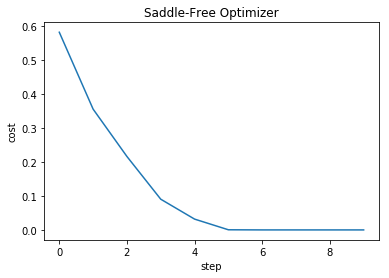

In [3]:
history, opt_name = test()
    
# Plot the cost
plt.plot(history)
plt.ylabel('cost')
plt.xlabel('step')
plt.title(opt_name + ' Optimizer')
plt.show()